Volume Fraction: 0.648
0.0001
0.0002
0.0005
0.001
0.002
0.005
0.01
0.032
0.1
1.0
10.0


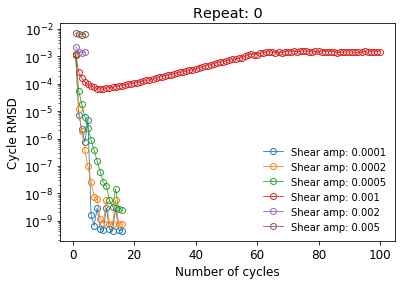

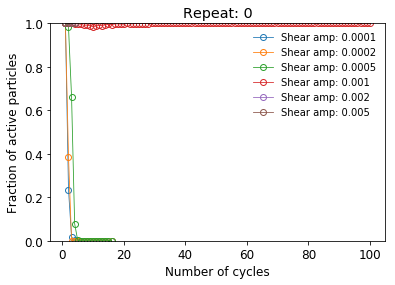

Volume Fraction: 0.648
0.001


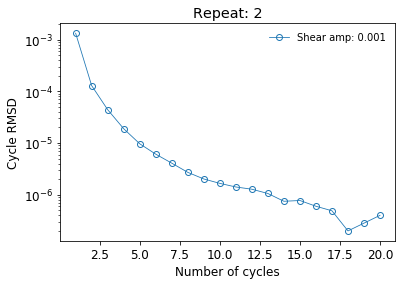

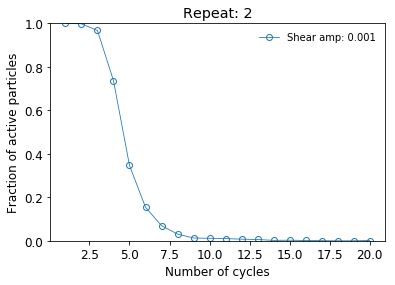

Volume Fraction: 0.648
0.001


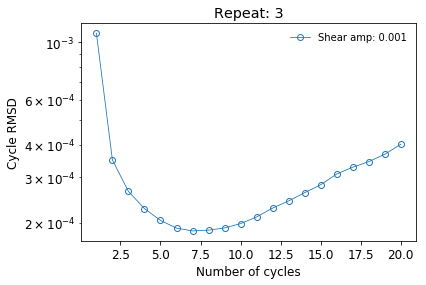

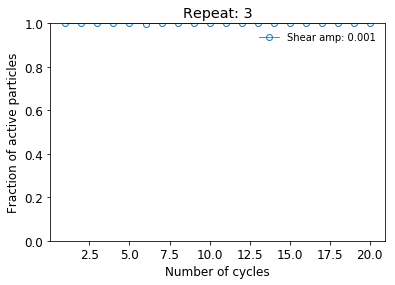

Exponent = 1.098


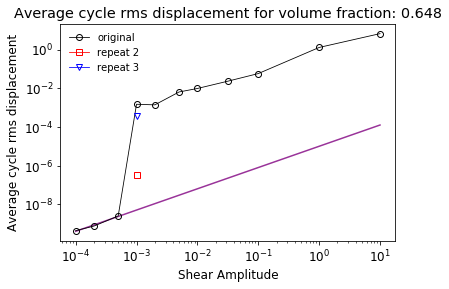

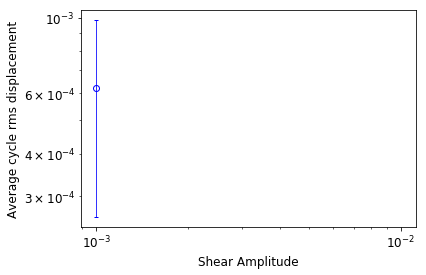

Completed...
Time: 17.076961 s


In [4]:
### this code plots rdf and radial profiles for displacement/contacts from text files produced by contacts_new.py ###

import matplotlib.pyplot as plt
import time
import numpy as np
from scipy import stats
from os import listdir
import re
from operator import itemgetter
from scipy.optimize import curve_fit
start = time.time()
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)


# function to calculate radial distribution function and contacts/displacement radial profile
def calc_cycle_displacement(n, x, y, z, box_dim, box_shear, active_dis):
    rms = np.zeros(len(x) - 1)
    active = np.zeros(len(rms))
    error_i = np.zeros(len(rms))
    r_2 = np.zeros([len(rms), n])
    for c in range(len(rms)):
        active_particles = 0
        for i in range(n):
            # distance from particle position at start of cycle to position at start of next cycle
            dx = (x[c+1][i] - x[c][i]) - np.around((x[c+1][i] - x[c][i]) / box_dim[0]) * box_dim[0]
            dy = (y[c+1][i] - y[c][i]) - np.around((y[c+1][i] - y[c][i]) / box_dim[1]) * box_dim[1]
            dz = (z[c+1][i] - z[c][i]) - np.around((z[c+1][i] - z[c][i]) / box_dim[2]) * box_dim[2]
            # correct for shear along xz
            dx -= np.around((z[c+1][i] - z[c][i]) / box_dim[2]) * box_shear[1]
            # total distance squared between particles at end/beginning of cycle
            r_2[c][i] = dx ** 2 + dy ** 2 + dz ** 2
            
            if np.sqrt(r_2[c][i]) > active_dis:
                active_particles += 1
        active[c] = active_particles / n
        
        rms_i = np.sqrt(np.mean(r_2[c]))
        if rms_i > 0.0:
            rms[c] = rms_i
        else:
            rms[c] = 1e-7  # smallest change in displacement that could be calculated
        error_2_i = np.std(r_2[c]) / np.sqrt(len(r_2[c]))  # error in MSD for individual cycle
        error_i[c] = 0.5 / rms[c] * error_2_i  # error in RMSD for individual cycle
    #error = np.sqrt(np.sum(error_i ** 2)) / len(error_i)
    #error = error_i[-1]
    error = np.std(rms[-3:]) / np.sqrt(len(rms[-3:]))
    
    
    return rms, error, active


def tryfloat(s):
    try:
        return float(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    amp = s[14:-5]
    amp = float(amp)
    #breakdown = [ tryfloat(c) for c in re.split('([0-9]+)', s) ]
    return amp

def alphanum_key_repeat(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    amp = s[14:-13]
    amp = float(amp)
    #breakdown = [ tryfloat(c) for c in re.split('([0-9]+)', s) ]
    return amp


def func(x, a, b, c, d, e):
   return a*np.exp(-b*x)+c*np.exp(-d*x)+e

def fit_curve(x, y, guess):
    xx = np.linspace(x[3], x[-3], 1000)
    popt, pcov = curve_fit(func, x[3:-3], y[3:-3], guess)
    #errors = np.sqrt(np.diag(pcov))
    yy = func(xx, *popt)
    return xx, yy, popt


def find_inflexion(x, y):
    grad = np.gradient(x, y)
    curv = np.gradient(x, grad)
    return np.argmin(curv)


def get_vol_fracs(path):
    all_folders = listdir(path)
    vol_fracs = []
    for folder in all_folders:
        if 'volume_fraction_' in folder:
            vol_fracs.append(float(folder[-5:]))
    return vol_fracs


def plot_micro(vol_frac, repeats, all_amps, all_cycle_dis, all_errors):
    
    colors = ['red', 'blue', 'green', 'magenta']
    markers = ['s', 'v', '^', '*']
    plt.figure()
    plt.xscale('log')
    plt.yscale('log')
    #plt.ylim(1e-2, 1e2)
    #plt.xlim(1e-1, 1e1)
    x = np.log(all_amps[0])
    y = np.log(all_cycle_dis[0])
    slope, intercept = np.polyfit(x[:3], y[:3], 1)
    print('Exponent = %.3f' % slope)
    xx = np.linspace(x[0], x[-1], 1000)
    yy = intercept + slope * xx
    plt.plot(np.exp(xx), np.exp(yy), color='purple', alpha=0.8)
    #plt.errorbar(all_amps[0], all_cycle_dis[0], yerr=all_errors[0], marker='o', color='black', mfc='none', lw=0.8, capsize=2, label='original')
    plt.plot(all_amps[0], all_cycle_dis[0], marker='o', color='black', mfc='none', lw=0.8, label='original')
    for r in range(1, repeats):
        #plt.errorbar(all_amps[r], all_cycle_dis[r], yerr=all_errors[r], marker='o', mfc='none', color=colors[r-1], lw=0.8, capsize=2, label='repeat %i' % (r+1))
        plt.plot(all_amps[r], all_cycle_dis[r], marker=markers[r-1], mfc='none', color=colors[r-1], lw=0.8, label='repeat %i' % (r+1))
    plt.xlabel('Shear Amplitude')
    plt.ylabel('Average cycle rms displacement')
    plt.legend(loc=0)
    plt.legend(frameon=False)
    plt.title('Average cycle rms displacement for volume fraction: %.3f' % vol_frac)
    #plt.savefig('%s/mean_cycle_displacement_%.3f.png' % (fig_path, vol_frac))
    
    avg_amps = []
    avg_dis = []
    avg_errors = []
    for m in range(len(all_amps[1])):
        dis = []
        for a in range(len(all_amps[0])):
            if all_amps[0][a] == all_amps[1][m]:
                dis.append(all_cycle_dis[0][a])
                break
        for l in range(1, len(all_amps)):
            dis.append(all_cycle_dis[l][m])
        dis = np.array(dis)
        avg_dis.append(np.mean(dis))
        avg_errors.append(np.sqrt(np.var(dis) / len(dis)))
        avg_amps.append(all_amps[1][m])
    
    plt.figure()
    plt.xscale('log')
    plt.yscale('log')
    plt.errorbar(avg_amps, avg_dis, marker='o', color='blue', mfc='none', lw=0.8, yerr=avg_errors, capsize=2)
    plt.xlabel('Shear Amplitude')
    plt.ylabel('Average cycle rms displacement')
            
    
    plt.show()
    
    return None
    

def calc_micro_reversibility(vol_frac, repeat):
    data_path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_data/volume_fraction_%.3f' % vol_frac
    all_files = listdir(data_path)
    files = []
    if repeat < 1:
        for file in all_files:
            if ".dump" in file and "repeat" not in file and "large" not in file and "super" not in file:
                files.append(file)
        files.sort(key=alphanum_key)
    else:
        for file in all_files:
            if ".dump" in file and "repeat%i" % repeat in file and "large" not in file and "super" not in file:
                files.append(file)
        files.sort(key=alphanum_key_repeat)

        
    print('Volume Fraction: %g' % vol_frac)
    shear_amps = np.zeros(len(files))
    
    if repeat < 1:
        for i in range(len(files)):
            shear_amps[i] = (float(files[i][14:-5]))
    else:
        for i in range(len(files)):
            shear_amps[i] = (float(files[i][14:-13]))
            
    avg_cycle_rmsd = np.zeros(len(shear_amps)) # radial distance from given particle
    errors = np.zeros(len(shear_amps))
    active_frac = []
    cycle_rmsd = []
    
    for a in range(len(shear_amps)):
        shear_amp = shear_amps[a]
        print(shear_amp)
        #shear_amp /= round((1250 * (4 /3) * np.pi * (0.7 ** 3 + 0.5 ** 3) / vol_frac) ** (1 / 3) * 1000) / 1000
        file = files[a]
        timesteps = []
        all_x = []
        all_y = []
        all_z = []
    
        # reads the datafile and stores relevant data in arrays
        with open('%s/%s' % (data_path, file)) as f:
            raw = f.readlines()
            f.close()
        raw = ([x.strip() for x in raw])
        nt = raw.count('ITEM: TIMESTEP')  # number of entries in data file (timesteps)
        n = int(raw[3].split()[0])  # number of particles
    
        for t in range(nt):
            x = []; y = []; z = []
            box_bounds = []
            data = []
            for i in range(n+9):
                index = i + t * (n + 9)
        # reads the timestep
                if i == 1:
                    timestep = int(raw[index])
                    timesteps.append(timestep)
        
        # reads box boundaries
                if 5 <= i < 8:
                    box_bounds.append(list(map(float, raw[index].split())))

        # discards first nine lines and split each line into a list of floats
                if i > 8:
                    data.append(list(map(float, raw[index].split())))
        # sort data by particle ID
            sorted_data = sorted(data, key=itemgetter(0))
            
            for k in range(len(sorted_data)):
                x.append(sorted_data[k][1])
                y.append(sorted_data[k][2])
                z.append(sorted_data[k][3])
            
            box_bounds = np.array(box_bounds)
            #print('box_bounds:', box_bounds)
            # box shear [xy xz yz]
            box_shear = box_bounds[:, -1]
            # box dimensions [lx ly lz]
            xlo = box_bounds[0][0] - min(0.0, box_shear[0], box_shear[1], box_shear[0] + box_shear[1])
            xhi = box_bounds[0][1] - max(0.0, box_shear[0], box_shear[1], box_shear[0] + box_shear[1])
            ylo = box_bounds[1][0] - min(0.0, box_shear[2])
            yhi = box_bounds[1][1] - max(0.0, box_shear[2])
            zlo = box_bounds[2][0]
            zhi = box_bounds[2][1]
            box_dim = np.array([xhi - xlo, yhi - ylo, zhi - zlo])
        
            #print('box dimensions:', box_dim)
            #print('box shear:', box_shear, '\n')

            all_x.append(x)
            all_y.append(y)
            all_z.append(z)
        
        all_x = np.array(all_x)
        all_y = np.array(all_y)
        all_z = np.array(all_z)
    
    
        #cycle_indices = int((period / timestep_length) / (timesteps[-1] - timesteps[-2]))
        rmsd, error, active = calc_cycle_displacement(n, all_x, all_y, all_z, box_dim, box_shear, active_dis)
        avg_cycle_rmsd[a] = np.mean(rmsd[-2:])
        #avg_cycle_rmsd[a] = rmsd[-1]
        cycle_rmsd.append(rmsd)
        errors[a] = error
        active_frac.append(active)
    
    if len(cycle_rmsd) < 6:
        indices = np.arange(len(cycle_rmsd))
    else:
        indices = np.arange(6)
    
    cycle_rmsd = np.array(cycle_rmsd)
    plt.figure()
    for q in indices:
        cycle = np.arange(1, len(cycle_rmsd[q])+1)
        plt.semilogy(cycle, cycle_rmsd[q], marker='o', mfc='none', lw=0.8, label='Shear amp: %g' % shear_amps[q])
    plt.xlabel('Number of cycles')
    plt.ylabel('Cycle RMSD')
    plt.title('Repeat: %i' % repeat)
    plt.legend(loc=0)
    plt.legend(frameon=False)
    plt.show()
    
    active_frac = np.array(active_frac)
    plt.figure()
    for q in indices:
        cycle = np.arange(1, len(cycle_rmsd[q])+1)
        plt.plot(cycle, active_frac[q], marker='o', mfc='none', lw=0.8, label='Shear amp: %g' % shear_amps[q])
    plt.xlabel('Number of cycles')
    plt.ylabel('Fraction of active particles')
    plt.title('Repeat: %i' % repeat)
    plt.legend(loc=0)
    plt.legend(frameon=False)
    plt.ylim(0, 1)
    plt.show()
    
        
    return shear_amps, avg_cycle_rmsd, errors


        
### code to be executed ###

path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_data'
fig_path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_plots/cycle_displacement'
vol_frac = 0.648
repeats = 3
timestep_length = 0.00032149
period = 964.47
active_dis = 1e-5

all_amps = []
all_cycle_dis = []
all_errors = []

amps, cycle_dis, err = calc_micro_reversibility(vol_frac, 0)
all_amps.append(amps)
all_cycle_dis.append(cycle_dis)
all_errors.append(err)

for r in range(2, repeats+1):
    amps, cycle_dis, err = calc_micro_reversibility(vol_frac, r)
    all_amps.append(amps)
    all_cycle_dis.append(cycle_dis)
    all_errors.append(err)
    
plot_micro(vol_frac, repeats, all_amps, all_cycle_dis, all_errors)

    
end = time.time()
print('Completed...')
print('Time: %f s' % (end-start))